In [23]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import genextreme

import rasterio
import matplotlib.gridspec as gridspec

from cartopy.crs import LambertConformal
import matplotlib
import matplotlib.patches as patches


os.chdir('/Users/louise/Documents/PJTS/ECCE')

import ssl
import certifi

ssl._create_default_https_context = ssl.create_default_context
ssl._create_default_https_context().load_verify_locations(certifi.where())

**Goal:** Analyze and visualize the outputs of the trained models.

This notebook focuses on understanding the spatial behavior and internal mechanisms of the models by studying the influence of each covariate and the geographical distribution of the estimated parameters.

**Idea:** By exploring both global metrics and spatial visualizations, we aim to identify which covariates have the greatest influence, how the model captures spatial variability, and whether there are patterns that reflect topographical or climatic features.

# 1. Assessing Covariate Importance (via AIC contribution)

To evaluate the contribution of each covariate, we use an AIC-based approach. For each covariate, we compute the AIC of a reduced model where that covariate is removed, and compare it to the AIC of the full model. The difference (AIC_full - AIC_reduced) indicates how much worse the model performs without that covariate.

This method is relevant because the AIC (Akaike Information Criterion) balances model fit and complexity — a lower AIC means a better trade-off. A large increase in AIC when a covariate is removed suggests that this covariate plays an important role in explaining the data.


In [24]:
# Download of AIC data obtained from the R script

# --- Resolution 48 ---
df = pd.read_csv('data/6_AIC/AIC_suivi48.csv')
for i in range(1, len(df)):
    key = df.loc[i, 'col']
    if key[0:4] == 'loc_' :
        key = key[4:]
    elif key[0:6] == 'scale_':
        key = key[6:]
    df.loc[i, 'col'] = key

df['liste_param'] = ''
df.loc[df.param == 'scale', 'liste_param'] = r'$\sigma$'
df.loc[df.param == 'mu', 'liste_param'] = r'$\mu$'

df['aic'] -= df.loc[df.col.isna(), 'aic'].iloc[0]
df = df.loc[df.col.notna()]

# --- Resolution 12 ---
df12 = pd.read_csv('data/6_AIC/AIC_suivi12.csv')
for i in range(1, len(df12)):
    key = df12.loc[i, 'col']
    param = df12.loc[i, 'param']
    if param == 'mu' :
        key = key[4:]
    elif param == 'scale' :
        key = key[6:]
    df12.loc[i, 'col'] = key

df12['liste_param'] = ''
df12.loc[df12.param == 'mu', 'liste_param'] = r'$\mu$'
df12.loc[df12.param == 'scale', 'liste_param'] = r'$\sigma$'

df12['aic'] -= df12.loc[df12.col.isna(), 'aic'].iloc[0]
df12 = df12.loc[df12.col.notna()]


# Add associated color 
#   --> blue for topography information
#   --> gray from low resolution data

colors_df = df["col"].apply(
    lambda x: "blue" if x in ["alt_mean50", "alt_std50", "alt", 'alt_mean20', 'alt_std20'] else "gray"
)
colors_df12 = df12["col"].apply(
    lambda x: "blue" if x in ["alt_mean50", "alt_std50", "alt", 'alt_mean20', 'alt_std20'] else "gray"
)


df['color'] = colors_df
df12['color'] = colors_df12

df_sorted = df.sort_values(by=["color", "aic"], ascending=[False, True]).reset_index(drop=True)
df12_sorted = df12.sort_values(by=["color", "aic"], ascending=[False, True]).reset_index(drop=True)


In [25]:
df12_sorted

aic         col  param liste_param color
0   277.818820      shape1     mu       $\mu$  gray
1   450.925668        loc1  scale    $\sigma$  gray
2   945.002027        loc2     mu       $\mu$  gray
3   946.106593      scale2  scale    $\sigma$  gray
4  1473.302807      scale1  scale    $\sigma$  gray
5  5457.363500        loc1     mu       $\mu$  gray
6   576.416156  alt_mean50     mu       $\mu$  blue
7  1679.398762         alt     mu       $\mu$  blue

In [26]:
df_sorted

aic         col  param liste_param color
0   669.048636        loc2     mu       $\mu$  gray
1  2017.976766        loc1     mu       $\mu$  gray
2   535.908232         alt  scale    $\sigma$  blue
3  2745.004995  alt_mean50  scale    $\sigma$  blue
4  2979.931331         alt     mu       $\mu$  blue
5  4198.326717  alt_mean50     mu       $\mu$  blue

In [27]:
dico_name = {
    'loc1': r'$\mu_1$',
    'loc2': r'$\mu_2$',
    'scale1': r'$\sigma_1$',
    'scale2': r'$\sigma_2$',
    'shape1': r'$\xi_1$',
    'alt': 'h',
    'alt_mean50': r'$h_m$',
    'alt_mean20': r'$h_m$'
}

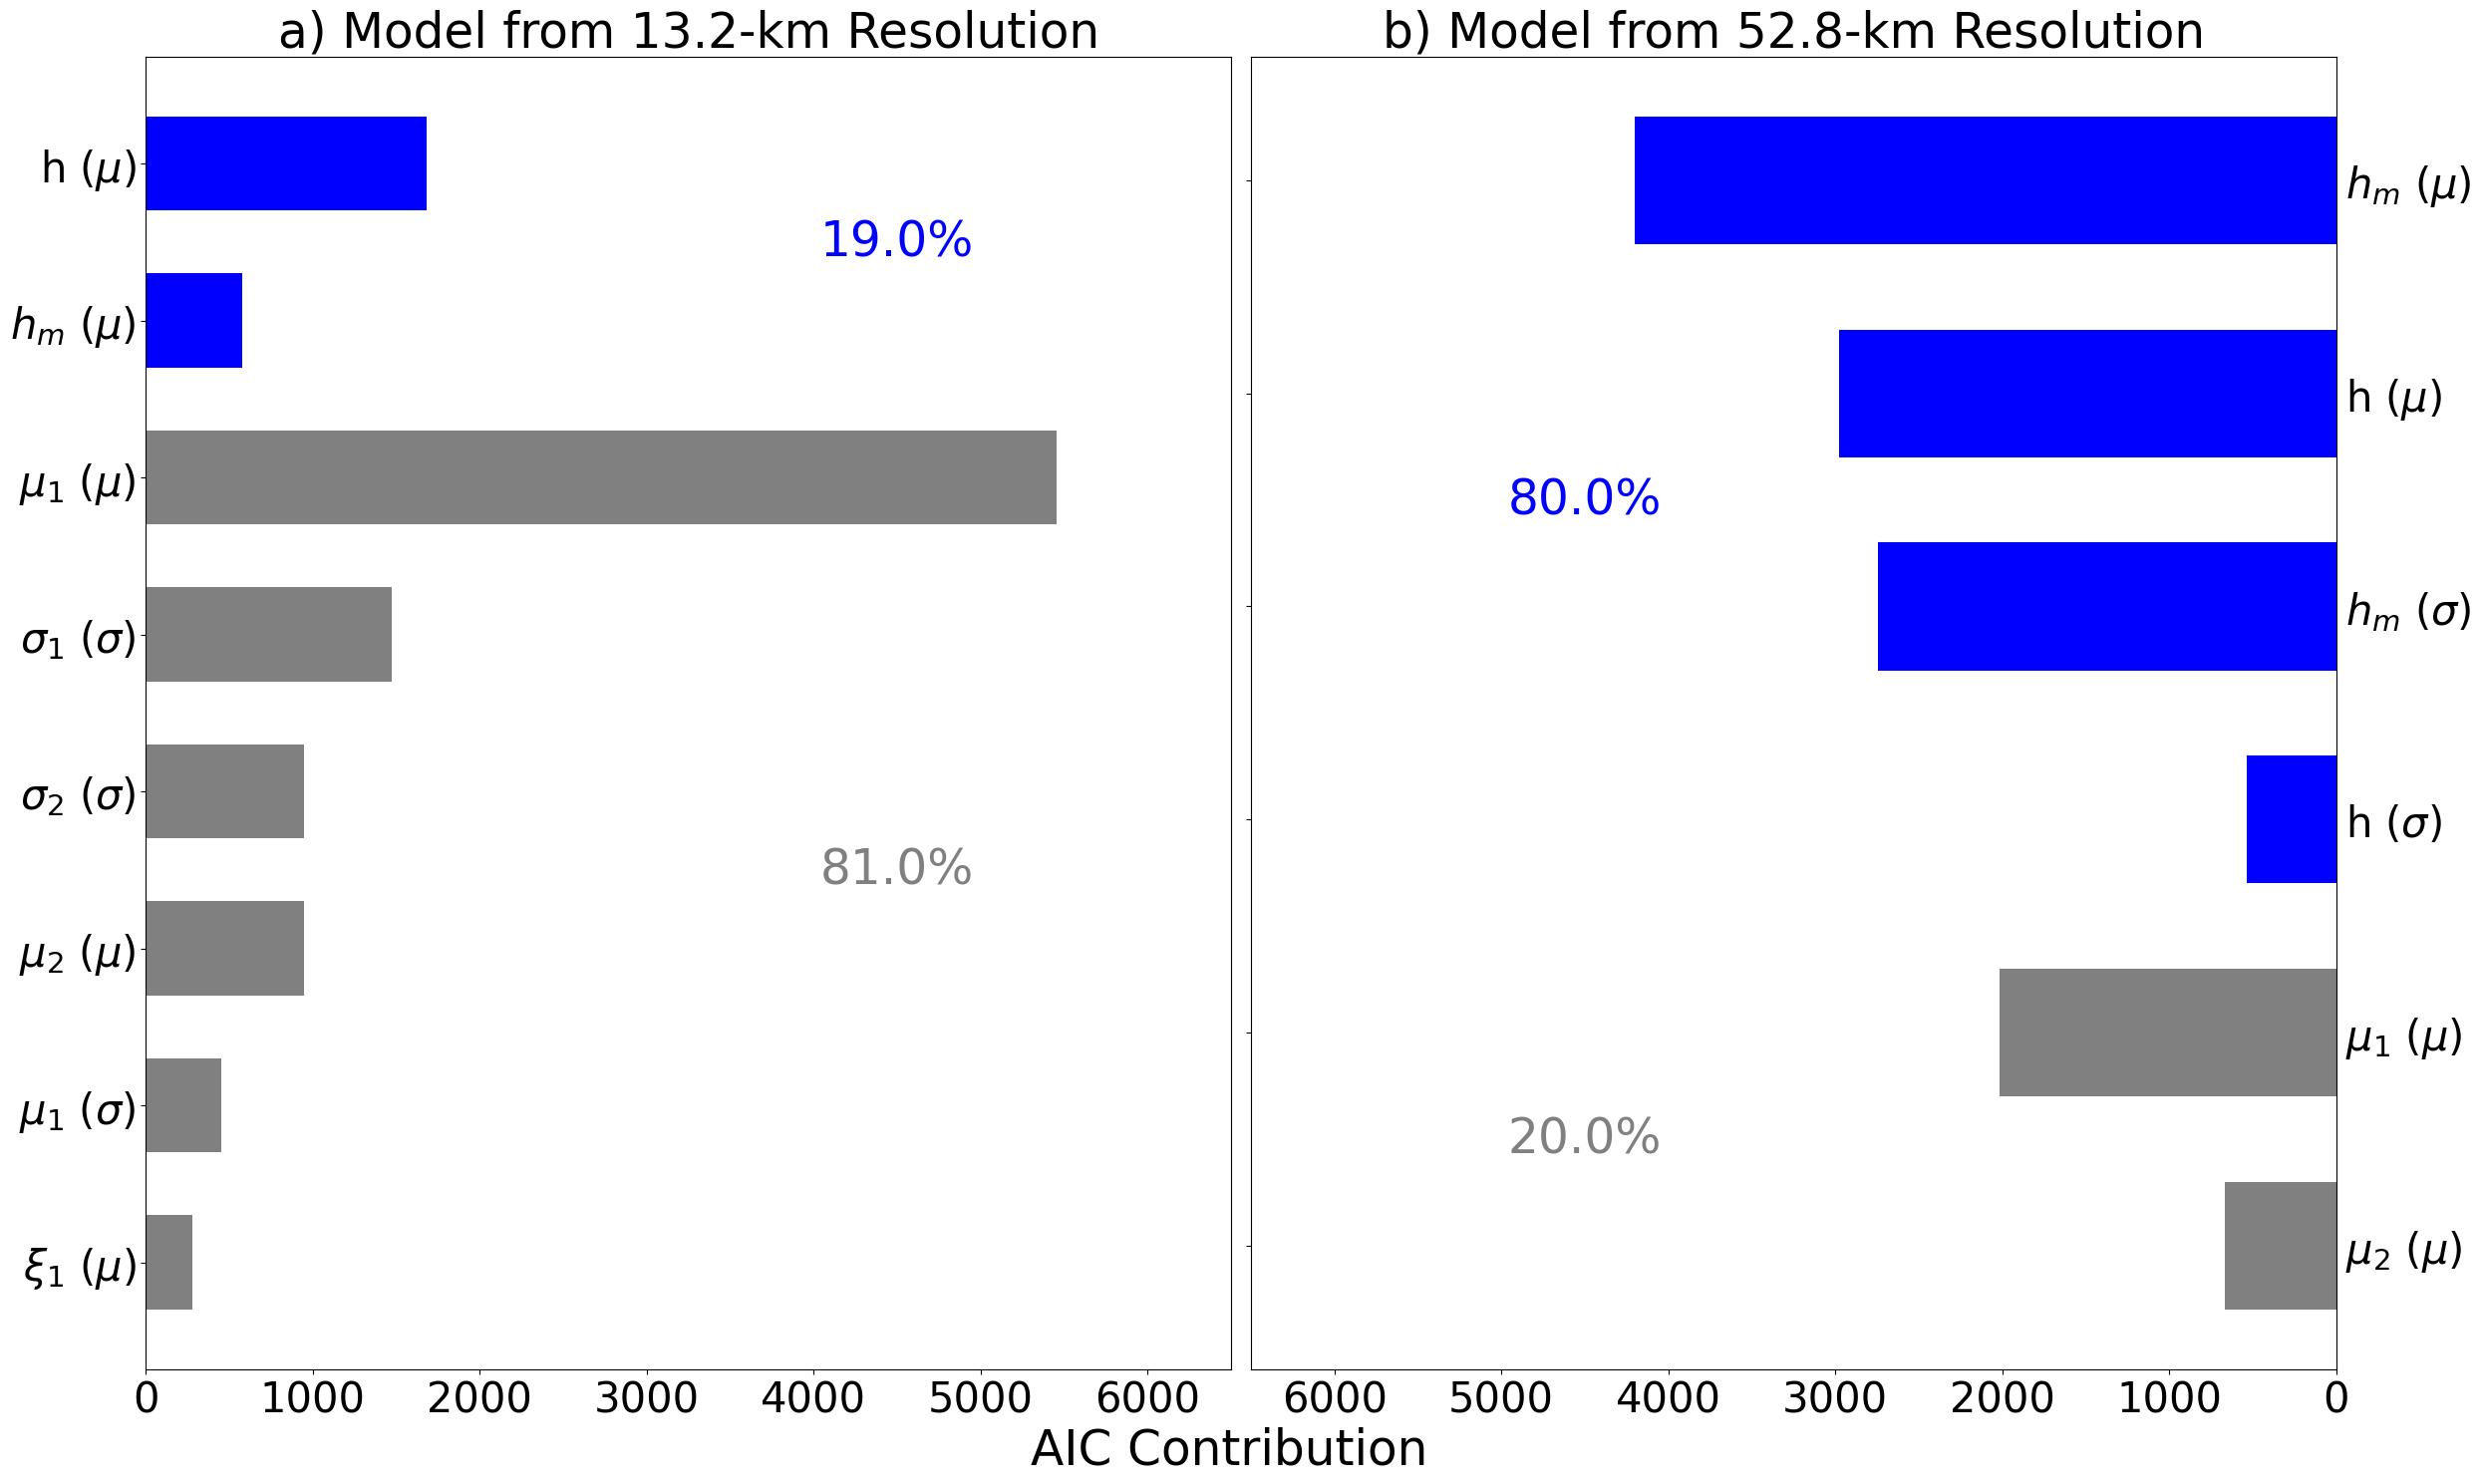

In [28]:
# Param fig 
text_size = 35
bar_width = 0.6 

# ----------------
# Left --> Res 12
# ----------------

# Barplot 

fig, axes = plt.subplots(1, 2, figsize=(25, 15))


axes[0].barh(
    df12_sorted["col"] + " (" + df12_sorted["liste_param"] + ")",
    df12_sorted["aic"], 
    color=list(df12_sorted.color),
    height=bar_width,
)

axes[0].tick_params(labelsize=text_size-5) 
axes[0].set_yticks(range(len(df12_sorted)))
axes[0].set_yticklabels([dico_name[col] + " (" + param + ")" for col, param in zip(df12_sorted["col"], df12_sorted["liste_param"])])
axes[0].set_xlim(0, 6500)

# Add % 

axes[0].text(
    x=4500, 
    y=6.5,  
    s=str(round(np.sum(df12_sorted.loc[df12_sorted.color == 'blue', 'aic'])/np.sum(df12_sorted.aic)*100, 0))+"%", 
    color="blue", 
    fontsize=text_size, 
    ha="center", 
    va="center",
)

axes[0].text(
    x=4500, 
    y=2.5, 
    s=str(round(np.sum(df12_sorted.loc[df12_sorted.color == 'gray', 'aic'])/np.sum(df12_sorted.aic)*100, 0))+"%", 
    color="gray", 
    fontsize=text_size, 
    ha="center", 
    va="center",
)
axes[0].set_title('a) Model from 13.2-km Resolution', fontsize=text_size)


# ----------------
# Right --> Res 48
# ----------------

# Barplot 

axes[1].barh(
    df_sorted["col"] + " (" + df_sorted["liste_param"] + ")",
    df_sorted["aic"], 
    color=list(df_sorted.color),
    height=bar_width,
)
axes[1].set_xlabel("AIC Contribution                                                                         ", fontsize=text_size)
axes[1].tick_params(labelsize=text_size-5) 
axes[1].invert_xaxis()
axes[1].set_yticks(range(len(df_sorted)))

axes[1].set_yticklabels([dico_name[col] + " (" + param + ")" for col, param in zip(df_sorted["col"], df_sorted["liste_param"])])
axes[1].tick_params(axis='y', labelright=True, labelleft=False)  
axes[1].set_xlim(6500, 0)


# Add % 

axes[1].text(
    x=4500, 
    y=3.5, 
    s=str(round(np.sum(df_sorted.loc[df_sorted.color == 'blue', 'aic'])/np.sum(df_sorted.aic)*100, 0))+"%", 
    color="blue", 
    fontsize=text_size, 
    ha="center", 
    va="center",
)

axes[1].text(
    x=4500, 
    y=0.5,  
    s=str(round(np.sum(df_sorted.loc[df_sorted.color == 'gray', 'aic'])/np.sum(df_sorted.aic)*100, 0))+"%", 
    color="gray", 
    fontsize=text_size, 
    ha="center", 
    va="center",
)

axes[1].set_title('b) Model from 52.8-km Resolution', fontsize=text_size)

plt.savefig("Figures_End/Fig_4.pdf", format='pdf', dpi = 300)
plt.tight_layout()
plt.show()

# 2. Visualizing GEV Parameters Across Switzerland

We visualize the spatial distribution of the estimated GEV parameters across Switzerland to better understand how the model captures regional variations in extreme precipitation.

In our case, the goal is not to assess how well the model predicts individual extreme values, but rather how accurately it estimates the full GEV distribution — the family we chose to represent extremes. Therefore, we focus on evaluating the quality of the fitted distributions themselves. To do this, we use the Cramér–von Mises error, which measures the distance between two probability distributions. This allows us to compare the predicted distribution to the observed one in a statistically meaningful way.

While all GEV parameters (location, scale, and shape) influence the distribution, the **location parameter** plays a particularly important role. It shifts the distribution along the value axis and has a strong influence on the estimated quantiles — especially the lower ones. As such, it often dominates the overall behavior of the GEV distribution and is crucial when interpreting spatial patterns in extremes.

## 2.1. Present


In [29]:
df_results = pd.read_csv('data/Results/results_pp12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_results.head(5)

rlat  rlon  scale_pred  shape_pred  loc_pred
0  -1.2 -2.84     0.00274    0.195905  0.003860
1  -1.2 -2.82     0.00274    0.195905  0.003865
2  -1.2 -2.80     0.00274    0.195905  0.003949
3  -1.2 -2.78     0.00274    0.195905  0.004209
4  -1.2 -2.76     0.00274    0.195905  0.004292

In [30]:
df_results = pd.read_csv('data/Results/results_pp12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_cova = pd.read_csv('data/1_rework/data2_12.csv')[['rlat', 'rlon', 'loc1', 'scale1', 'shape1', 'alt']]
df_cova = pd.merge(df_cova, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv')[['rlat', 'rlon', 'lat', 'lon']], on = ['rlat', 'rlon'], how = 'left')
df_param = pd.read_csv('data/2_True_Parameters/gev2_param_true_present.csv')[['rlat', 'rlon', 'loc', 'scale', 'shape']]

df = pd.merge(df_results, df_cova, on = ['rlat', 'rlon'], how = 'outer')
df = pd.merge(df, df_param, on = ['rlat', 'rlon'], how = 'outer')

df.drop_duplicates(inplace = True)

In [31]:
for lat in df.rlat.unique(): df.loc[df.rlat == lat, 'lat'] = np.mean(df.loc[df.rlat == lat, 'lat'])
for lon in df.rlon.unique(): df.loc[df.rlon == lon, 'lon'] = np.mean(df.loc[df.rlon == lon, 'lon'])

In [16]:
def rgev(n, loc, scale, shape):
    """Génère des échantillons de la distribution GEV."""
    c = -shape 
    return genextreme.rvs(c, loc=loc, scale=scale, size=n)

def pgev(x, loc, scale, shape):
    """Calcule la fonction de répartition cumulative (CDF) de la GEV."""
    c = -shape  
    return genextreme.cdf(x, c, loc=loc, scale=scale)


n_samples = 1000

df['distCVM'] = np.nan
df['distCVM2'] = np.nan

for i, row in df.iterrows():
    if (not pd.isna(row['scale'])) & (not pd.isna(row['scale_pred'])):

        samples_gev1 = rgev(n_samples, loc=row['loc_pred'], scale=row['scale_pred'], shape=row['shape_pred'])
        samples_gev2 = rgev(n_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        
        sorted_samples = np.sort(samples_gev1)
        
        empirical_cdf = (2 * np.arange(1, n_samples + 1) - 1) / (2 * n_samples)
        theoretical_cdf = pgev(sorted_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        distCVM = (1 / (12 * n_samples)) + np.sum((empirical_cdf - theoretical_cdf) ** 2)
        
        df.at[i, 'distCVM'] = distCVM


for i, row in df.iterrows():
    if not pd.isna(row['scale']):

        samples_gev1 = rgev(n_samples, loc=row['loc1'], scale=row['scale1'], shape=row['shape1'])
        samples_gev2 = rgev(n_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        
        sorted_samples = np.sort(samples_gev1)
        
        empirical_cdf = (2 * np.arange(1, n_samples + 1) - 1) / (2 * n_samples)
        theoretical_cdf = pgev(sorted_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        distCVM = (1 / (12 * n_samples)) + np.sum((empirical_cdf - theoretical_cdf) ** 2)
        
        df.at[i, 'distCVM2'] = distCVM


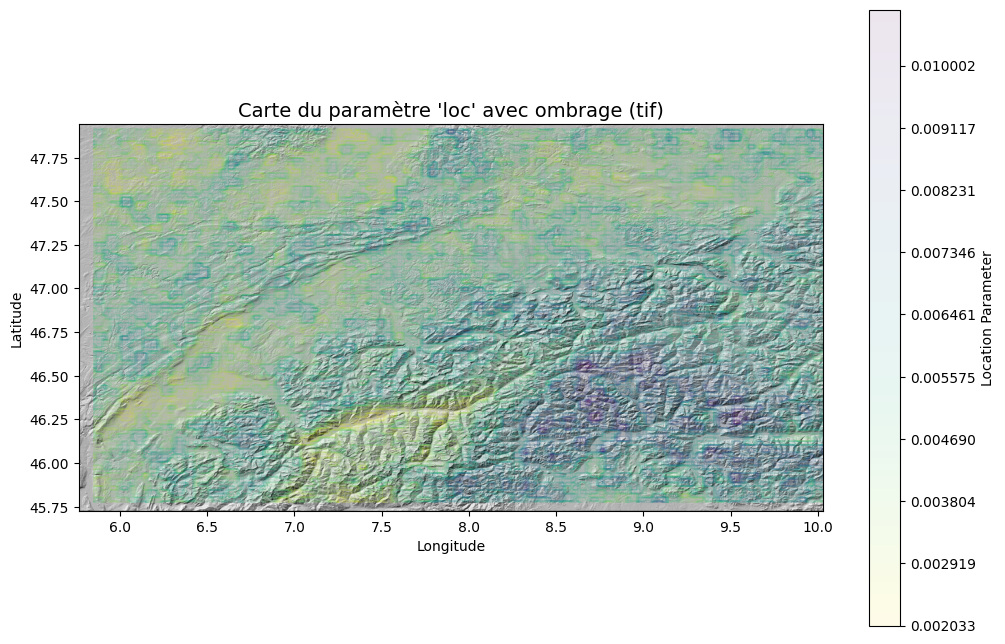

In [17]:

with rasterio.open("data/Maps/viz.hh_hillshade.tif") as src:
    hillshade = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 200)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 200)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

grid_param = griddata(
    (df['lat'], df['lon']),
    df['loc'],
    (grid_lat, grid_lon),
    method='nearest'
)

fig, ax = plt.subplots(figsize=(12, 8))


c = ax.contourf(
    grid_lon, grid_lat, grid_param,
    levels=np.linspace(np.nanmin(grid_param), np.nanmax(grid_param), 100),
    cmap='viridis_r', alpha=0.1
)


ax.imshow(
    hillshade, cmap='gray', extent=extent,
    origin='upper', alpha=1
)

cbar = plt.colorbar(c, ax=ax)
cbar.set_label("Location Parameter")

ax.set_title("Carte du paramètre 'loc' avec ombrage (tif)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


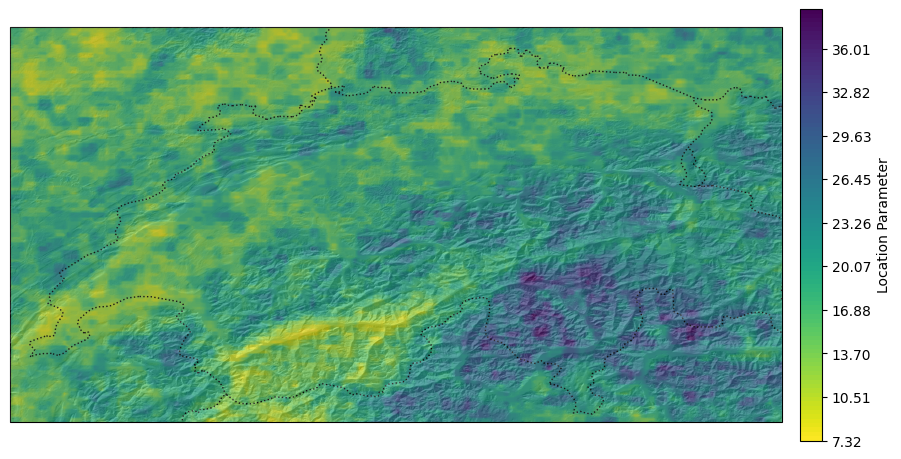

In [19]:
grid_param = griddata(
    (df['lat'], df['lon']),
    df['loc'] *3600,
    (grid_lat, grid_lon),
    method='nearest'
)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

c = ax.contourf(
    grid_lon, grid_lat, grid_param,
    transform=ccrs.PlateCarree(),
    levels=np.linspace(np.nanmin(grid_param), np.nanmax(grid_param), 100),
    cmap='viridis_r'
)

ax.imshow(
    hillshade, cmap='Greys', extent=extent,
    origin='upper', alpha=0.3, zorder=10
)

ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

ax.set_extent([
    df['lon'].min(), df['lon'].max(),
    df['lat'].min(), df['lat'].max()
], crs=ccrs.PlateCarree())


cbar = plt.colorbar(c, ax=ax, orientation="vertical", pad=0.02, shrink=0.7)
cbar.set_label("Location Parameter")
ax.set_title("", fontsize=14)

plt.show()

In [20]:
cols = ['loc', 'loc1', 'loc_pred']
for col in cols : df[col] = df[col]*3600

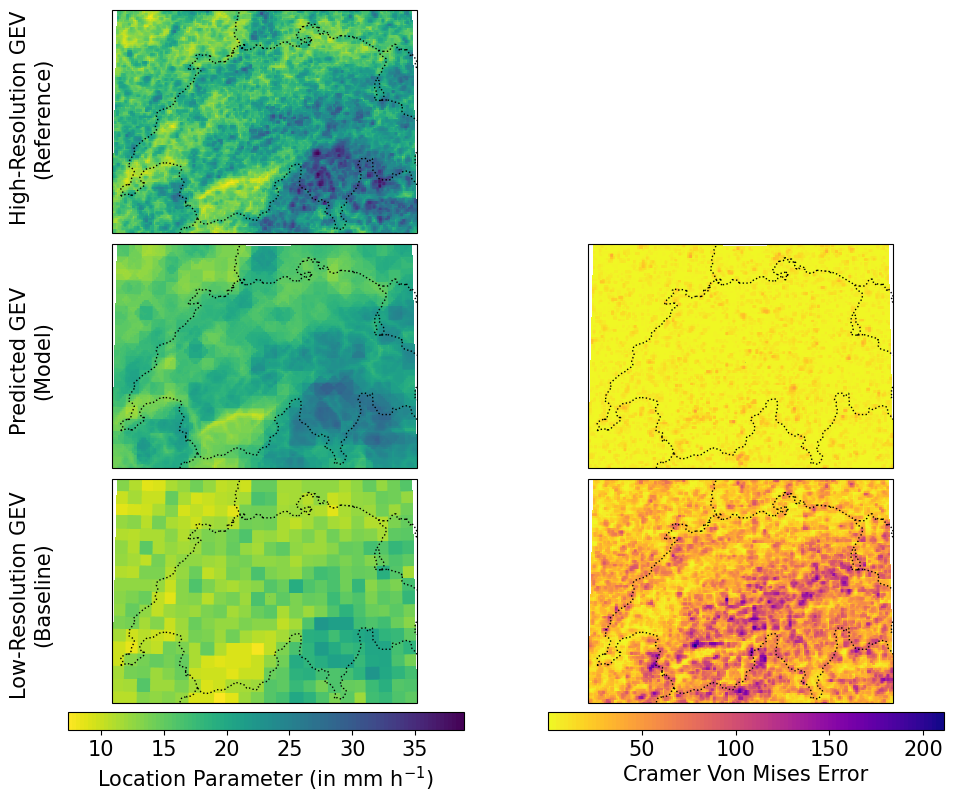

In [21]:
with rasterio.open("data/Maps/viz.hh_hillshade.tif") as src:
    hillshade = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 300)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 300)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

loc_range = (
    np.nanmin([df['loc'].min(), df['loc_pred'].min(), df['loc1'].min()]),
    np.nanmax([df['loc'].max(), df['loc_pred'].max(), df['loc1'].max()])
)
cvm_range = (
    np.nanmin([df['distCVM'].min(), df['distCVM2'].min()]),
    np.nanmax([df['distCVM'].max(), df['distCVM2'].max()])
)


def plot_map(ax, var, cmap, levels):
    grid_param = griddata(
        (df['lat'], df['lon']),
        df[var],
        (grid_lat, grid_lon),
        method='nearest'
    )
    im = ax.contourf(
        grid_lon, grid_lat, grid_param,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(*levels, 100),
        cmap=cmap
    )
    ax.imshow(hillshade, cmap='Greys', extent=extent, origin='upper', alpha=0.3, zorder=10)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()])
    return im

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], hspace=0.05, wspace=0.05)

proj = LambertConformal(central_longitude=8, central_latitude=46.8)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
im1 = plot_map(ax1, 'loc', 'viridis_r', loc_range)

ax2 = fig.add_subplot(gs[1, 0], projection=proj)
plot_map(ax2, 'loc_pred', 'viridis_r', loc_range)

ax3 = fig.add_subplot(gs[2, 0], projection=proj)
plot_map(ax3, 'loc1', 'viridis_r', loc_range)

ax5 = fig.add_subplot(gs[1, 1], projection=proj)
im2 = plot_map(ax5, 'distCVM', 'plasma_r', cvm_range)

ax6 = fig.add_subplot(gs[2, 1], projection=proj)
plot_map(ax6, 'distCVM2', 'plasma_r', cvm_range)

cbar_ax1 = fig.add_axes([0.15, 0.08, 0.33, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal',
                   ticks=np.arange(0, 41, 5))
cb1.set_label("Location Parameter (in mm h$^{-1}$)", fontsize=15)
cb1.ax.tick_params(labelsize=15) 

cbar_ax2 = fig.add_axes([0.55, 0.08, 0.33, 0.02])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal',
                   ticks=np.arange(0, 201, 50))
cb2.set_label("Cramer Von Mises Error", fontsize=15)
cb2.ax.tick_params(labelsize=15) 

fig.text(0.12, 0.76, 'High-Resolution GEV\n(Reference)', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.12, 0.49, 'Predicted GEV\n(Model)', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.12, 0.23, 'Low-Resolution GEV\n(Baseline)', va='center', ha='center', rotation='vertical', fontsize=15)

plt.savefig("Fig_4_BR.png")
plt.show()


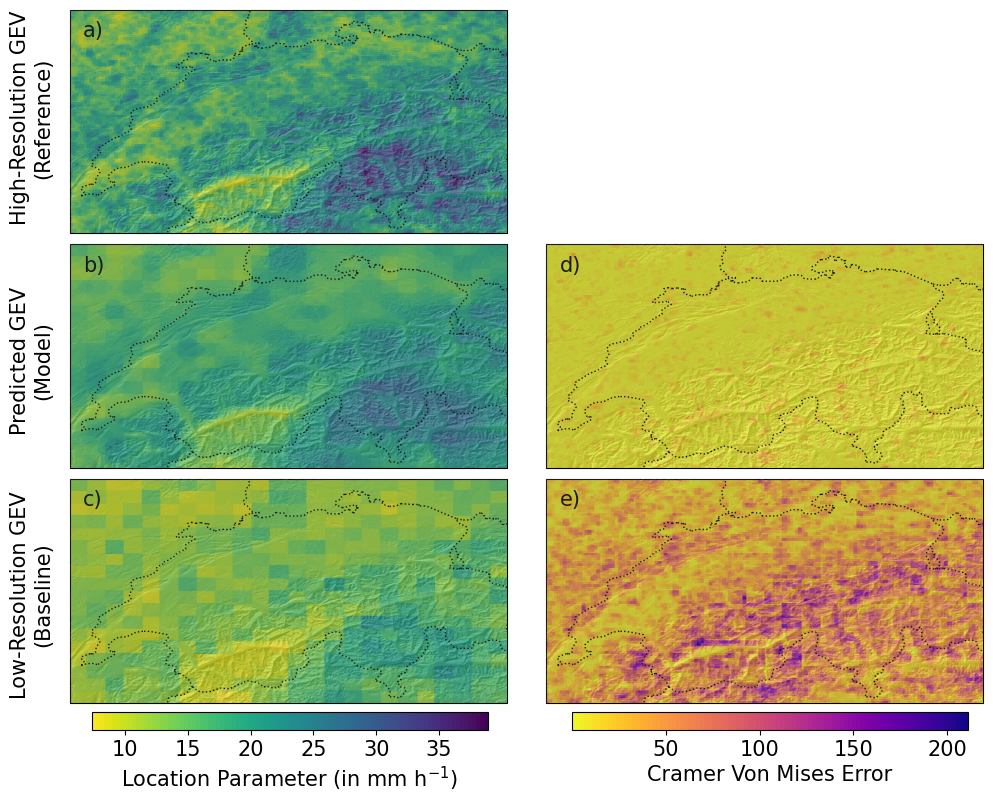

In [22]:
# === Charger les données et le hillshade ===
with rasterio.open("data/Maps/viz.hh_hillshade.tif") as src:
    hillshade = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 300)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 300)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

# === Définir les plages pour les couleurs ===
loc_range = (
    np.nanmin([df['loc'].min(), df['loc_pred'].min(), df['loc1'].min()]),
    np.nanmax([df['loc'].max(), df['loc_pred'].max(), df['loc1'].max()])
)
cvm_range = (
    np.nanmin([df['distCVM'].min(), df['distCVM2'].min()]),
    np.nanmax([df['distCVM'].max(), df['distCVM2'].max()])
)

# === Fonction de traçage ===
def plot_map(ax, var, cmap, levels):
    grid_param = griddata(
        (df['lat'], df['lon']),
        df[var],
        (grid_lat, grid_lon),
        method='nearest'
    )
    im = ax.contourf(
        grid_lon, grid_lat, grid_param,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(*levels, 100),
        cmap=cmap
    )
    ax.imshow(hillshade, cmap='Greys', extent=extent, origin='upper', alpha=0.3, zorder=10)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()])
    return im

# === Création de la figure ===
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], hspace=0.05, wspace=0.05)

proj = ccrs.PlateCarree()

# === Cartes GEV (gauche) ===
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
im1 = plot_map(ax1, 'loc', 'viridis_r', loc_range)
ax1.text(0.03, 0.88, "a)", transform=ax1.transAxes, fontsize=15)

ax2 = fig.add_subplot(gs[1, 0], projection=proj)
plot_map(ax2, 'loc_pred', 'viridis_r', loc_range)
ax2.text(0.03, 0.88, "b)", transform=ax2.transAxes, fontsize=15)

ax3 = fig.add_subplot(gs[2, 0], projection=proj)
plot_map(ax3, 'loc1', 'viridis_r', loc_range)
ax3.text(0.03, 0.88, "c)", transform=ax3.transAxes, fontsize=15)


# === Cartes CVM (droite) ===
ax5 = fig.add_subplot(gs[1, 1], projection=proj)
im2 = plot_map(ax5, 'distCVM', 'plasma_r', cvm_range)
ax5.text(0.03, 0.88, "d)", transform=ax5.transAxes, fontsize=15)


ax6 = fig.add_subplot(gs[2, 1], projection=proj)
plot_map(ax6, 'distCVM2', 'plasma_r', cvm_range)
ax6.text(0.03, 0.88, "e)", transform=ax6.transAxes, fontsize=15)


# === Ajouter les colorbars horizontales en bas ===
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.33, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal',
                   ticks=np.arange(0, 50, 5))
cb1.set_label("Location Parameter (in mm h$^{-1}$)", fontsize=15)
cb1.ax.tick_params(labelsize=15) 

cbar_ax2 = fig.add_axes([0.55, 0.08, 0.33, 0.02])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal',
                   ticks=np.arange(0, 201, 50))
cb2.set_label("Cramer Von Mises Error", fontsize=15)
cb2.ax.tick_params(labelsize=15) 

# === Ajouter les titres verticaux sur la gauche ===
fig.text(0.1, 0.76, 'High-Resolution GEV\n(Reference)', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.1, 0.49, 'Predicted GEV\n(Model)', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.1, 0.23, 'Low-Resolution GEV\n(Baseline)', va='center', ha='center', rotation='vertical', fontsize=15)

plt.savefig("Fig_5.pdf", format='pdf', dpi = 300)
plt.savefig("Fig_5.png")
plt.show()


## 2.1. Future

In [28]:
df_resultspf = pd.read_csv('data/Results/results_pf12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_resultspf.rename(columns = {'loc_pred' : 'loc_predpf', 'scale_pred' : 'scale_predpf', 'shape_pred' : 'shape_predpf'}, inplace = True)
df_resultsff = pd.read_csv('data/Results/results_ff12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_resultsff.rename(columns = {'loc_pred' : 'loc_predff', 'scale_pred' : 'scale_predff', 'shape_pred' : 'shape_predff'}, inplace = True)

df_cova = pd.read_csv('data/1_rework/dataf2_12.csv')[['rlat', 'rlon', 'loc1', 'scale1', 'shape1', 'alt']]
df_cova = pd.merge(df_cova, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv')[['rlat', 'rlon', 'lat', 'lon']], on = ['rlat', 'rlon'], how = 'left')
df_param = pd.read_csv('data/2_True_Parameters/gev2_param_true_future.csv')[['rlat', 'rlon', 'loc', 'scale', 'shape']]

df = pd.merge(df_resultspf, df_cova, on = ['rlat', 'rlon'], how = 'outer')
df = pd.merge(df, df_resultsff, on = ['rlat', 'rlon'], how = 'outer')
df = pd.merge(df, df_param, on = ['rlat', 'rlon'], how = 'outer')

df.drop_duplicates(inplace = True)

In [29]:
df['distCVM'] = np.nan
df['distCVMpf'] = np.nan
df['distCVMff'] = np.nan

for i, row in df.iterrows():
    if (not pd.isna(row['scale'])) & (not pd.isna(row['scale_predpf'])):

        samples_gev1 = rgev(n_samples, loc=row['loc_predpf'], scale=row['scale_predpf'], shape=row['shape_predpf'])
        samples_gev2 = rgev(n_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        
        sorted_samples = np.sort(samples_gev1)
        
        empirical_cdf = (2 * np.arange(1, n_samples + 1) - 1) / (2 * n_samples)
        theoretical_cdf = pgev(sorted_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        distCVM = (1 / (12 * n_samples)) + np.sum((empirical_cdf - theoretical_cdf) ** 2)

        df.at[i, 'distCVMpf'] = distCVM

for i, row in df.iterrows():
    if (not pd.isna(row['scale'])) & (not pd.isna(row['scale_predff'])):

        samples_gev1 = rgev(n_samples, loc=row['loc_predff'], scale=row['scale_predff'], shape=row['shape_predff'])
        samples_gev2 = rgev(n_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        
        sorted_samples = np.sort(samples_gev1)
        
        empirical_cdf = (2 * np.arange(1, n_samples + 1) - 1) / (2 * n_samples)
        theoretical_cdf = pgev(sorted_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        distCVM = (1 / (12 * n_samples)) + np.sum((empirical_cdf - theoretical_cdf) ** 2)
        
        df.at[i, 'distCVMff'] = distCVM


for i, row in df.iterrows():
    if not pd.isna(row['scale']):

        samples_gev1 = rgev(n_samples, loc=row['loc1'], scale=row['scale1'], shape=row['shape1'])
        samples_gev2 = rgev(n_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        
        sorted_samples = np.sort(samples_gev1)
        
        empirical_cdf = (2 * np.arange(1, n_samples + 1) - 1) / (2 * n_samples)
        theoretical_cdf = pgev(sorted_samples, loc=row['loc'], scale=row['scale'], shape=row['shape'])
        distCVM = (1 / (12 * n_samples)) + np.sum((empirical_cdf - theoretical_cdf) ** 2)
        
        df.at[i, 'distCVM'] = distCVM


In [30]:
cols = ['loc', 'loc1', 'loc_predpf', 'loc_predff']
for col in cols : df[col] = df[col]*3600

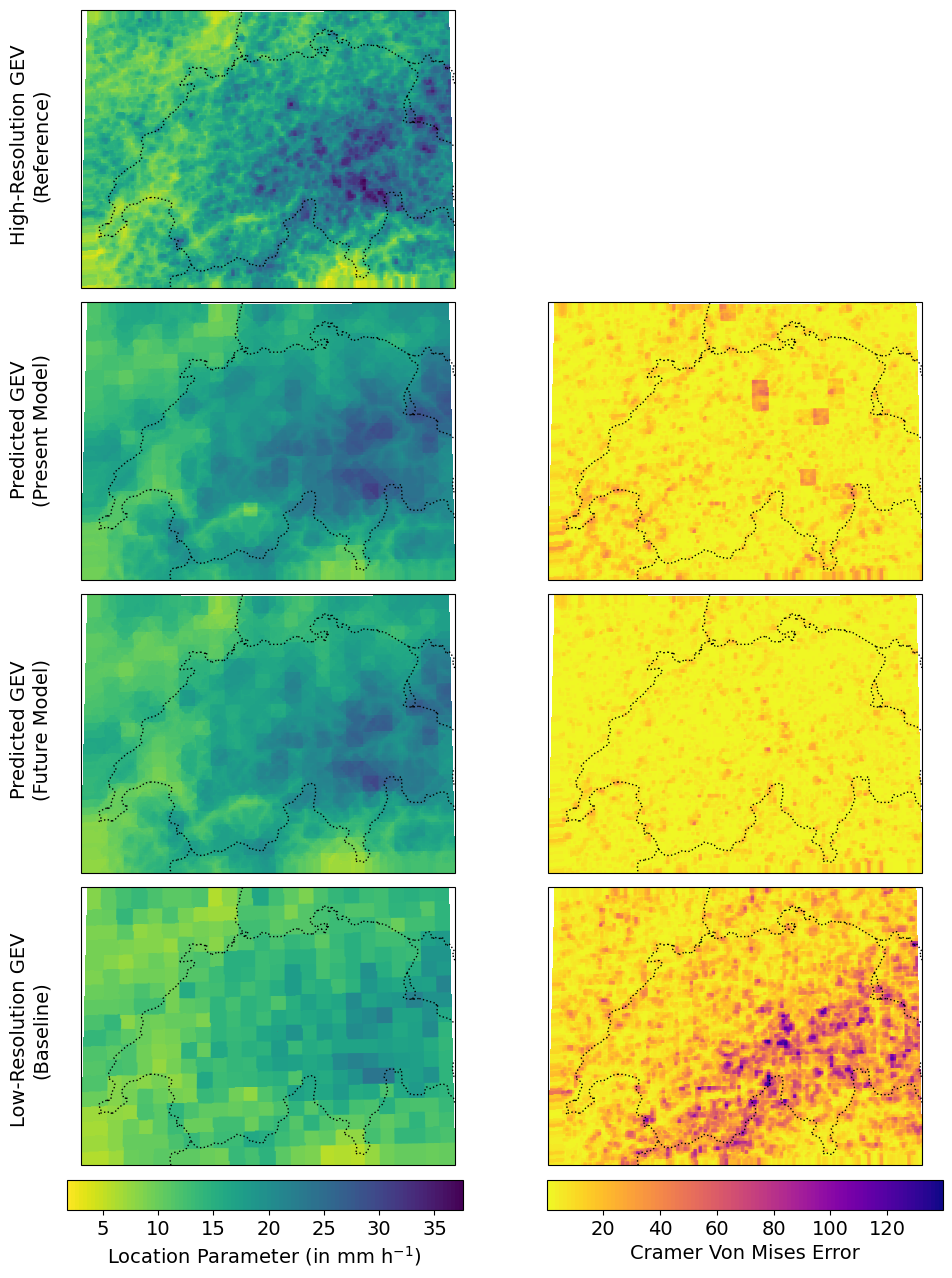

In [31]:
with rasterio.open("data/Maps/viz.hh_hillshade.tif") as src:
    hillshade = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 300)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 300)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)

loc_range = (
    np.nanmin([df['loc'].min(), df['loc_predpf'].min(), df['loc_predff'].min(), df['loc1'].min()]),
    np.nanmax([df['loc'].max(), df['loc_predpf'].max(), df['loc_predff'].max(), df['loc1'].max()])
)
cvm_range = (
    np.nanmin([df['distCVM'].min(), df['distCVMpf'].min(), df['distCVMff'].min()]),
    np.nanmax([df['distCVM'].max(), df['distCVMpf'].max(), df['distCVMff'].max()])
)

def plot_map(ax, var, cmap, levels):
    grid_param = griddata(
        (df['lat'], df['lon']),
        df[var],
        (grid_lat, grid_lon),
        method='nearest'
    )
    im = ax.contourf(
        grid_lon, grid_lat, grid_param,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(*levels, 100),
        cmap=cmap
    )
    ax.imshow(hillshade, cmap='Greys', extent=extent, origin='upper', alpha=0.3, zorder=10)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()])
    return im


fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1], hspace=0.05, wspace=0.01)

proj = LambertConformal(central_longitude=8, central_latitude=46.8)


ax1 = fig.add_subplot(gs[0, 0], projection=proj)
im1 = plot_map(ax1, 'loc', 'viridis_r', loc_range)

ax2 = fig.add_subplot(gs[1, 0], projection=proj)
plot_map(ax2, 'loc_predpf', 'viridis_r', loc_range)

ax3 = fig.add_subplot(gs[2, 0], projection=proj)
plot_map(ax3, 'loc_predff', 'viridis_r', loc_range)

ax4 = fig.add_subplot(gs[3, 0], projection=proj)
plot_map(ax4, 'loc1', 'viridis_r', loc_range)

ax5 = fig.add_subplot(gs[1, 1], projection=proj)
im2 = plot_map(ax5, 'distCVMpf', 'plasma_r', cvm_range)

ax6 = fig.add_subplot(gs[2, 1], projection=proj)
im2 = plot_map(ax6, 'distCVMff', 'plasma_r', cvm_range)

ax7 = fig.add_subplot(gs[3, 1], projection=proj)
plot_map(ax7, 'distCVM', 'plasma_r', cvm_range)

fontsize = 14

cbar_ax1 = fig.add_axes([0.15, 0.08, 0.33, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal',
                   ticks=np.arange(0, 41, 5))
cb1.ax.tick_params(labelsize=fontsize)
cb1.set_label("Location Parameter (in mm h$^{-1}$)", fontsize = fontsize)

cbar_ax2 = fig.add_axes([0.55, 0.08, 0.33, 0.02])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal',
                   ticks=np.arange(0, 201, 20))
cb2.ax.tick_params(labelsize=fontsize)
cb2.set_label("Cramer Von Mises Error", fontsize=fontsize)


fig.text(0.12, 0.79, 'High-Resolution GEV\n(Reference)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.12, 0.6, 'Predicted GEV\n(Present Model)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.12, 0.4, 'Predicted GEV\n(Future Model)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.12, 0.2, 'Low-Resolution GEV\n(Baseline)', va='center', ha='center', rotation='vertical', fontsize=fontsize)

plt.savefig("Fig_7_BR_NEW.png")
plt.show()


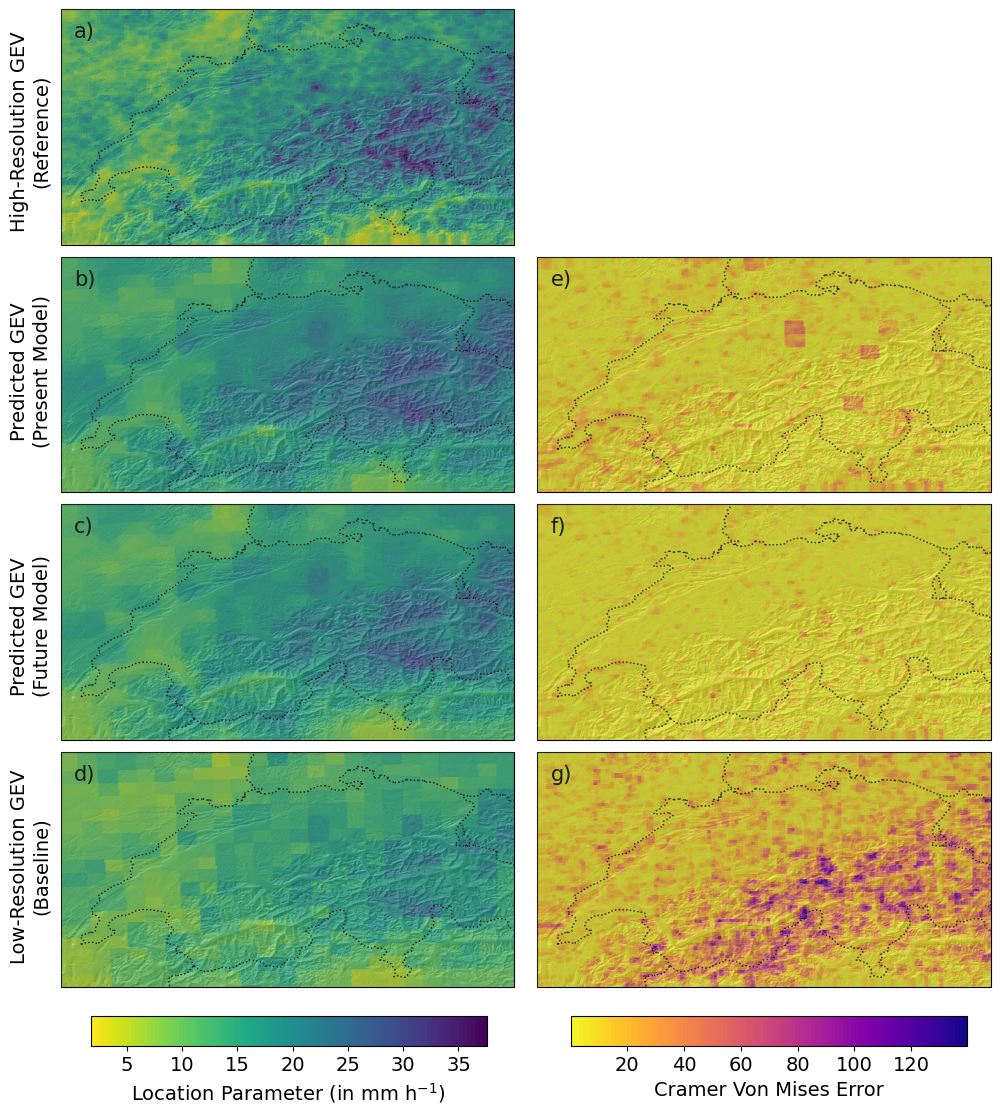

In [32]:
with rasterio.open("data/Maps/viz.hh_hillshade.tif") as src:
    hillshade = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

lat_vals = np.linspace(df['lat'].min(), df['lat'].max(), 300)
lon_vals = np.linspace(df['lon'].min(), df['lon'].max(), 300)
grid_lat, grid_lon = np.meshgrid(lat_vals, lon_vals)


loc_range = (
    np.nanmin([df['loc'].min(), df['loc_predpf'].min(), df['loc_predff'].min(), df['loc1'].min()]),
    np.nanmax([df['loc'].max(), df['loc_predpf'].max(), df['loc_predff'].max(), df['loc1'].max()])
)
cvm_range = (
    np.nanmin([df['distCVM'].min(), df['distCVMpf'].min(), df['distCVMff'].min()]),
    np.nanmax([df['distCVM'].max(), df['distCVMpf'].max(), df['distCVMff'].max()])
)


def plot_map(ax, var, cmap, levels):
    grid_param = griddata(
        (df['lat'], df['lon']),
        df[var],
        (grid_lat, grid_lon),
        method='nearest'
    )
    im = ax.contourf(
        grid_lon, grid_lat, grid_param,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(*levels, 100),
        cmap=cmap
    )
    ax.imshow(hillshade, cmap='Greys', extent=extent, origin='upper', alpha=0.3, zorder=10)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()])
    return im


fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1], hspace=-0.4, wspace=0.05)

proj = ccrs.PlateCarree()


ax1 = fig.add_subplot(gs[0, 0], projection=proj)
im1 = plot_map(ax1, 'loc', 'viridis_r', loc_range)
ax1.text(0.03, 0.88, "a)", transform=ax1.transAxes, fontsize=15)


ax2 = fig.add_subplot(gs[1, 0], projection=proj)
plot_map(ax2, 'loc_predpf', 'viridis_r', loc_range)
ax2.text(0.03, 0.88, "b)", transform=ax2.transAxes, fontsize=15)


ax3 = fig.add_subplot(gs[2, 0], projection=proj)
plot_map(ax3, 'loc_predff', 'viridis_r', loc_range)
ax3.text(0.03, 0.88, "c)", transform=ax3.transAxes, fontsize=15)


ax4 = fig.add_subplot(gs[3, 0], projection=proj)
plot_map(ax4, 'loc1', 'viridis_r', loc_range)
ax4.text(0.03, 0.88, "d)", transform=ax4.transAxes, fontsize=15)


ax5 = fig.add_subplot(gs[1, 1], projection=proj)
im2 = plot_map(ax5, 'distCVMpf', 'plasma_r', cvm_range)
ax5.text(0.03, 0.88, "e)", transform=ax5.transAxes, fontsize=15)


ax6 = fig.add_subplot(gs[2, 1], projection=proj)
im2 = plot_map(ax6, 'distCVMff', 'plasma_r', cvm_range)
ax6.text(0.03, 0.88, "f)", transform=ax6.transAxes, fontsize=15)


ax7 = fig.add_subplot(gs[3, 1], projection=proj)
plot_map(ax7, 'distCVM', 'plasma_r', cvm_range)
ax7.text(0.03, 0.88, "g)", transform=ax7.transAxes, fontsize=15)


fontsize = 14

cbar_ax1 = fig.add_axes([0.15, 0.13, 0.33, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal',
                   ticks=np.arange(0, 41, 5))
cb1.ax.tick_params(labelsize=fontsize)
cb1.set_label("Location Parameter (in mm h$^{-1}$)", fontsize = fontsize)

cbar_ax2 = fig.add_axes([0.55, 0.13, 0.33, 0.02])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal',
                   ticks=np.arange(0, 201, 20))
cb2.ax.tick_params(labelsize=fontsize)
cb2.set_label("Cramer Von Mises Error", fontsize=fontsize)

fig.text(0.1, 0.74, 'High-Resolution GEV\n(Reference)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.1, 0.58, 'Predicted GEV\n(Present Model)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.1, 0.41, 'Predicted GEV\n(Future Model)', va='center', ha='center', rotation='vertical', fontsize=fontsize)
fig.text(0.1, 0.25, 'Low-Resolution GEV\n(Baseline)', va='center', ha='center', rotation='vertical', fontsize=fontsize)

plt.savefig("Fig_8.pdf", format='pdf', dpi = 300)
plt.savefig("Fig_8.png")
plt.show()


# 3. Grid point analysis (example)

In [37]:
df_resultspf = pd.read_csv('data/Results/results_pf12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_resultspf.rename(columns = {'loc_pred' : 'loc_predpf', 'scale_pred' : 'scale_predpf', 'shape_pred' : 'shape_predpf'}, inplace = True)
df_resultsff = pd.read_csv('data/Results/results_ff12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_resultsff.rename(columns = {'loc_pred' : 'loc_predff', 'scale_pred' : 'scale_predff', 'shape_pred' : 'shape_predff'}, inplace = True)

df_cova = pd.read_csv('data/1_rework/dataf2_12.csv')[['rlat', 'rlon', 'loc1', 'scale1', 'shape1', 'alt']]
df_cova = pd.merge(df_cova, pd.read_csv('data/0_cluster/Topography/coordinate_transformer.csv')[['rlat', 'rlon', 'lat', 'lon']], on = ['rlat', 'rlon'], how = 'left')
df_param = pd.read_csv('data/2_True_Parameters/gev2_param_true_future.csv')[['rlat', 'rlon', 'loc', 'scale', 'shape']]

df = pd.merge(df_resultspf, df_cova, on = ['rlat', 'rlon'], how = 'outer')
df = pd.merge(df, df_resultsff, on = ['rlat', 'rlon'], how = 'outer')
df = pd.merge(df, df_param, on = ['rlat', 'rlon'], how = 'outer')

df.drop_duplicates(inplace = True)

In [38]:
df.head(5)

rlat  rlon  scale_predpf  shape_predpf  loc_predpf      loc1   scale1  \
0    -1.2 -2.84       0.00251      0.195905    0.002626  0.001649  0.00182   
33   -1.2 -2.82       0.00251      0.195905    0.002631  0.001649  0.00182   
66   -1.2 -2.80       0.00251      0.195905    0.002715  0.001649  0.00182   
99   -1.2 -2.78       0.00251      0.195905    0.002975  0.001649  0.00182   
132  -1.2 -2.76       0.00251      0.195905    0.003058  0.001649  0.00182   

       shape1         alt        lat       lon  scale_predff  shape_predff  \
0    0.425066   439.57074  45.726242  5.930880      0.002282      0.254603   
33   0.425066   451.95310  45.727276  5.959485      0.002282      0.254603   
66   0.425066   626.46466  45.728306  5.988092      0.002282      0.254603   
99   0.425066   990.02850  45.729324  6.016699      0.002282      0.254603   
132  0.425066  1105.49220  45.730335  6.045307      0.002282      0.254603   

     loc_predff       loc     scale     shape  
0      0.002140  0.001352  0.002016  1.000506  
33     0.002142  0.001608  0.002292  0.840394  
66     0.002184  0.001386  0.002036  1.034622  
99     0.002300  0.001869  0.002355  0.797388  
132    0.002355  0.001482  0.002127  0.988896

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5568/771120268.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


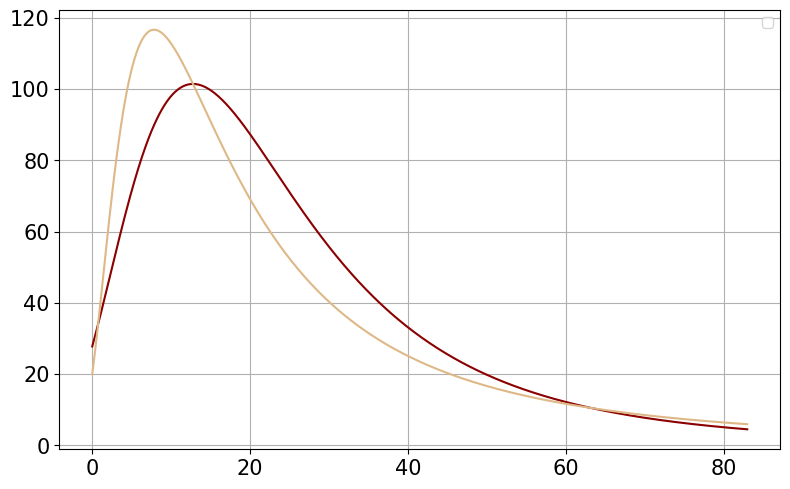

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5568/771120268.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


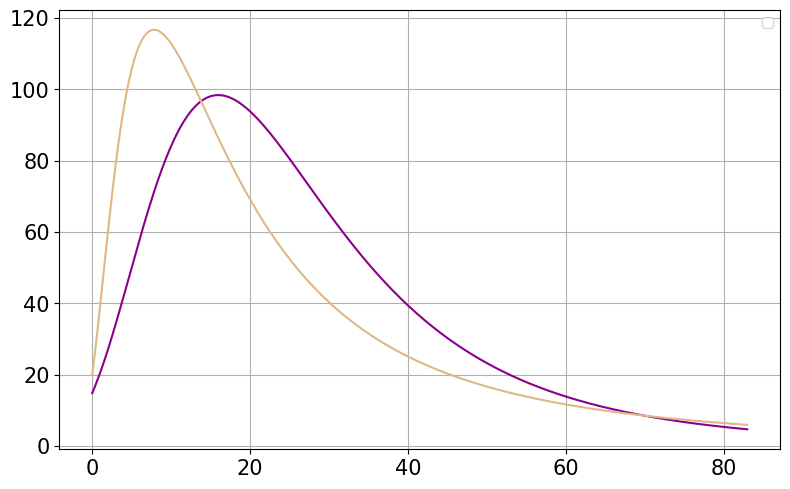

In [40]:
# Sélection aléatoire d’un couple (rlat, rlon)
unique_coords = df[['rlat', 'rlon']].drop_duplicates()
random_coord = unique_coords.sample(1).iloc[0]
rlat_random, rlon_random = random_coord['rlat'], random_coord['rlon']
#rlat_random, rlon_random =  -0.16, -2.84
df_local = df[(df['rlat'] == rlat_random) & (df['rlon'] == rlon_random)].copy()

c_pred = -df_local['shape_predff'].values[0]
loc_pred = df_local['loc_predff'].values[0]
scale_pred = df_local['scale_predff'].values[0]

c_true = -df_local['shape'].values[0]
loc_true = df_local['loc'].values[0]
scale_true = df_local['scale'].values[0]

x_raw = np.linspace(0, max(loc_true + 5*scale_true, loc_pred + 5*scale_pred), 500)

# Calcul des densités (dans l'unité d'origine)
pdf_pred = genextreme.pdf(x_raw, c_pred, loc=loc_pred, scale=scale_pred)
pdf_true = genextreme.pdf(x_raw, c_true, loc=loc_true, scale=scale_true)

# Conversion de l’axe x pour affichage uniquement
x_mm_h = x_raw * 3600  

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(x_mm_h, pdf_pred, color='darkred')
plt.plot(x_mm_h, pdf_true, color='burlywood')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------

c_pred = -df_local['shape_predpf'].values[0]
loc_pred = df_local['loc_predpf'].values[0]
scale_pred = df_local['scale_predpf'].values[0]


pdf_pred = genextreme.pdf(x_raw, c_pred, loc=loc_pred, scale=scale_pred)
pdf_true = genextreme.pdf(x_raw, c_true, loc=loc_true, scale=scale_true)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(x_mm_h, pdf_pred, color='darkmagenta')
plt.plot(x_mm_h, pdf_true, color='burlywood')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
rlat_random

np.float64(-0.8)

In [42]:
rlon_random

np.float64(-0.18)

# 4. Splines

An advantage of our method is its full interpretability through the use of splines. They allow us to precisely understand how the model reacts to changes in the value of each input feature. By comparing the learned splines across different models, we can gain insights into the relative influence of each variable and identify consistent or divergent patterns in model behavior.

### 4.1. Comparison : Res 6, 12, 24, 36, 48

We compare models with the same structure — that is, using the same features in the parameterization — but trained on input data at different initial resolutions, ranging from a coarse 48 km to a finer 6 km. This setup allows us to isolate the effect of resolution on the learned relationships and to examine how the influence of each feature evolves as the input data becomes more detailed.

In [2]:
def load_csvs_to_dict(directory, res):
    """
    Charge tous les fichiers CSV dans un répertoire correspondant au motif 'splines_loc_name.csv'
    et les stocke dans un dictionnaire avec le nom extrait de 'name' comme clé.

    Args:
        directory (str): Le chemin vers le répertoire contenant les fichiers CSV.

    Returns:
        dict: Un dictionnaire où les clés sont les noms extraits de 'name' et les valeurs sont des DataFrames pandas.
    """
    csv_dict = {}

    for filename in os.listdir(directory):

        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        
        if 's'+str(res)+"_loc_" in filename:
            name = filename.split("splines"+str(res)+"_loc_")[1].split(".csv")[0]
            csv_dict['loc_'+name] = df

        elif 's'+str(res)+'_scale_' in filename:
            name = filename.split("splines"+str(res)+"_scale_")[1].split(".csv")[0]
            csv_dict['scale_'+name] = df

    return csv_dict

directory_path = "data/5_Splines/present_2_12_24_36_48"
csv_documents6 = load_csvs_to_dict(directory_path, 6)
csv_documents12 = load_csvs_to_dict(directory_path, 12)
csv_documents24 = load_csvs_to_dict(directory_path, 24)
csv_documents36 = load_csvs_to_dict(directory_path, 36)
csv_documents48 = load_csvs_to_dict(directory_path, 48)

df_train_present48 = pd.read_csv('data/1_rework/data2_24_rework.csv')
df_train_present48 = df_train_present48.loc[(df_train_present48.Val == 0) & (df_train_present48.Test == 0),]
df_train_present48.drop(columns = ['TOT_PR'], inplace = True)
df_train_present48.drop_duplicates(inplace = True)

df_train_present36 = pd.read_csv('data/1_rework/data2_24_rework.csv')
df_train_present36 = df_train_present36.loc[(df_train_present36.Val == 0) & (df_train_present36.Test == 0),]
df_train_present36.drop(columns = ['TOT_PR'], inplace = True)
df_train_present36.drop_duplicates(inplace = True)

df_train_present24 = pd.read_csv('data/1_rework/data2_24_rework.csv')
df_train_present24 = df_train_present24.loc[(df_train_present24.Val == 0) & (df_train_present24.Test == 0),]
df_train_present24.drop(columns = ['TOT_PR'], inplace = True)
df_train_present24.drop_duplicates(inplace = True)

df_train_present12 = pd.read_csv('data/1_rework/data2_24_rework.csv')
df_train_present12 = df_train_present12.loc[(df_train_present12.Val == 0) & (df_train_present12.Test == 0),]
df_train_present12.drop(columns = ['TOT_PR'], inplace = True)
df_train_present12.drop_duplicates(inplace = True)

df_train_present6 = pd.read_csv('data/1_rework/data2_6_rework.csv')
df_train_present6 = df_train_present6.loc[(df_train_present6.Val == 0) & (df_train_present6.Test == 0),]
df_train_present6.drop(columns = ['TOT_PR'], inplace = True)
df_train_present6.drop_duplicates(inplace = True)

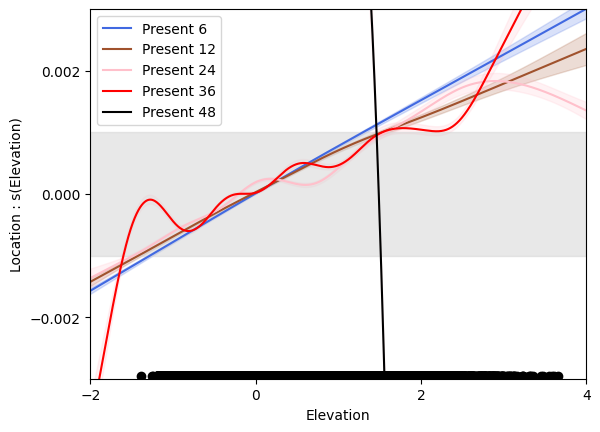

In [3]:
n = len(df_train_present12)
size = 25
var = 'loc_loc1'

df = csv_documents6[var]
plt.plot(df.alt, df.spline_values, color = 'royalblue', label = 'Present 6')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='royalblue', alpha=0.2)

df = csv_documents12[var]
plt.plot(df.alt, df.spline_values, color = 'sienna', label = 'Present 12')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='sienna', alpha=0.2)

df = csv_documents24[var]
plt.plot(df.alt, df.spline_values, color = 'pink', label = 'Present 24')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='pink', alpha=0.2)

df = csv_documents36[var]
plt.plot(df.alt, df.spline_values, color = 'red', label = 'Present 36')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='pink', alpha=0.2)

df = csv_documents48[var]
plt.plot(df.alt, df.spline_values, color = 'black', label = 'Present 48')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='pink', alpha=0.2)

plt.axhspan(-0.001, 0.001, color='lightgrey', alpha=0.5)

plt.scatter(df_train_present6.alt, [-0.00295]*n, color = 'black')
plt.legend()
plt.ylim(-0.003, 0.003)
plt.xlim(-2, 4)

plt.xlabel('Elevation')
plt.ylabel('Location : s(Elevation)')

plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.show()

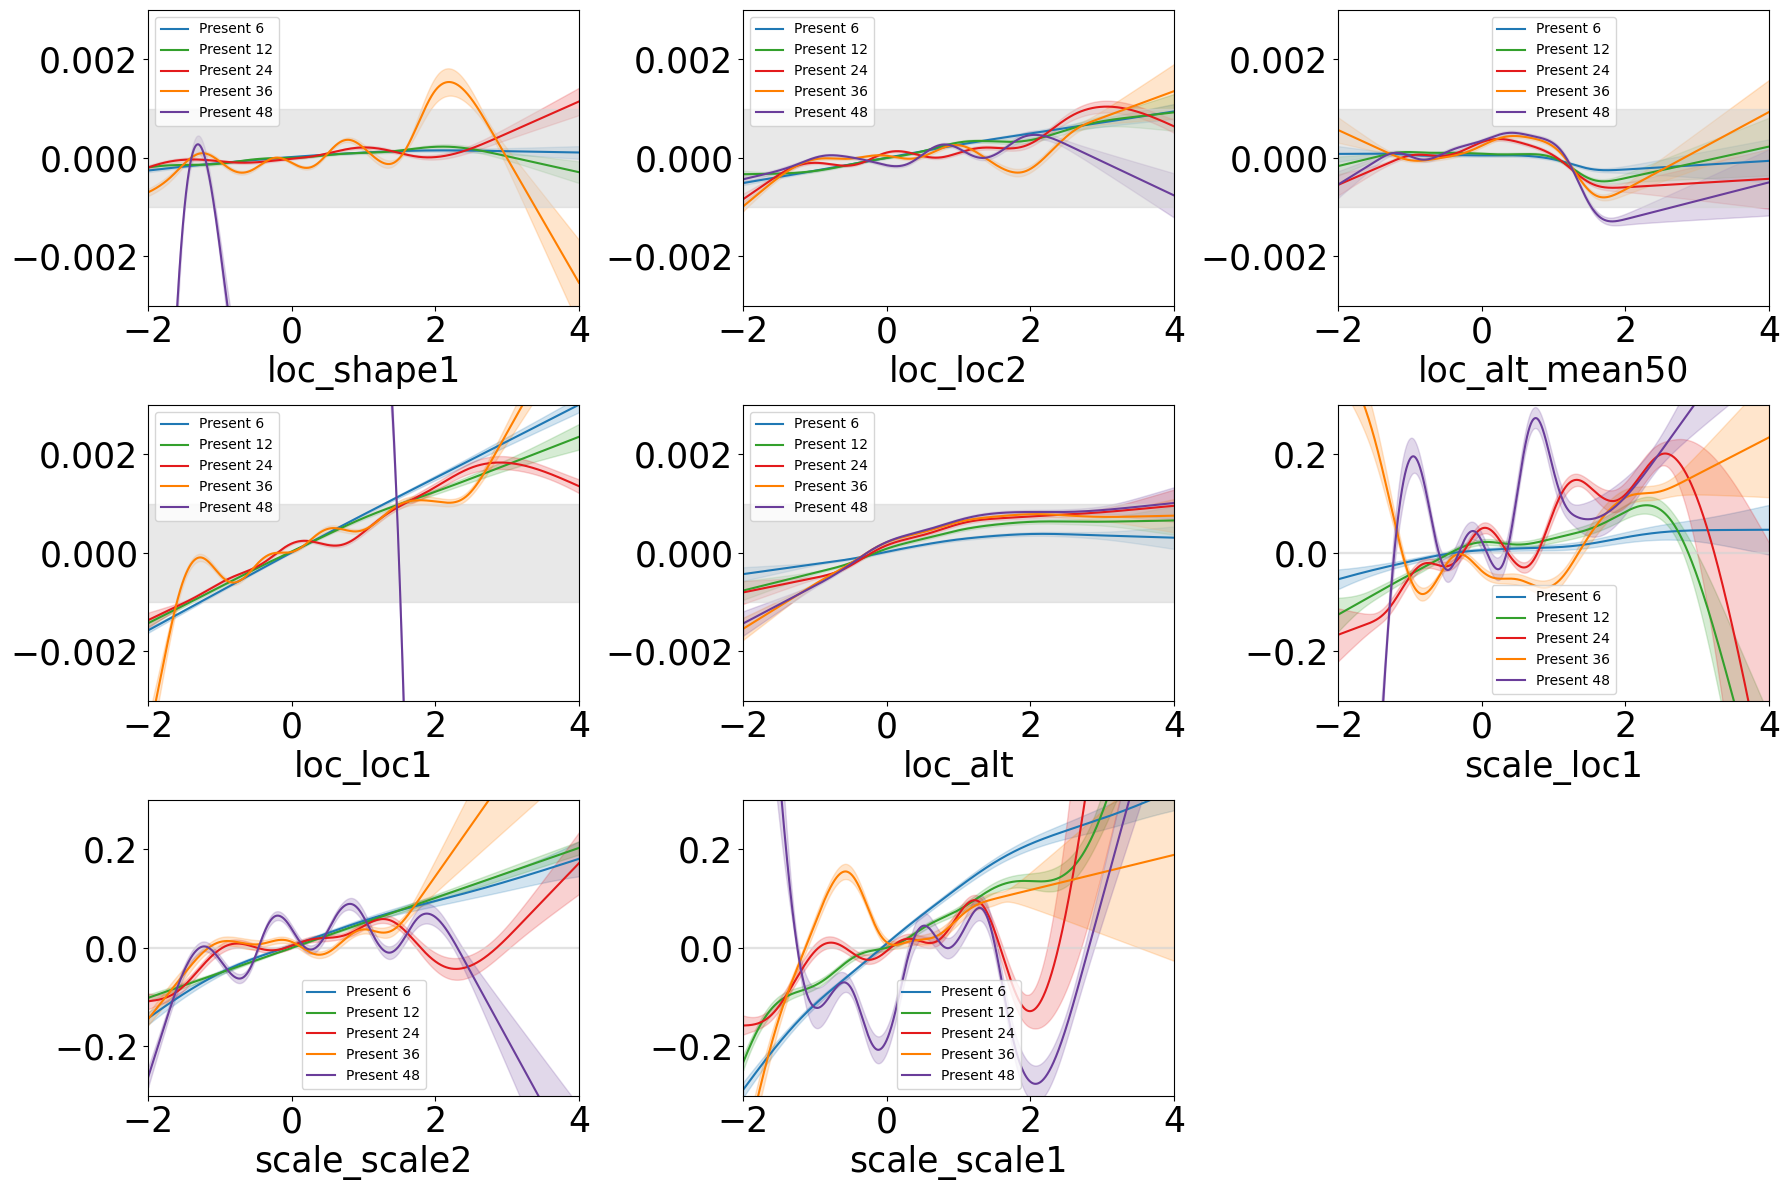

In [4]:
variables = list(csv_documents6.keys())

data_sources = {
    "Present 6": (csv_documents6, '#1f78b4'),  # Bleu
    "Present 12": (csv_documents12, '#33a02c'),  # Vert
    "Present 24": (csv_documents24, '#e31a1c'),  # Rouge vif
    "Present 36": (csv_documents36, '#ff7f00'),  # Orange
    "Present 48": (csv_documents48, '#6a3d9a')   # Violet
}

n = len(df_train_present12)
size = 25
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    for label, (df_source, color) in data_sources.items():
        df = df_source[var]
        ax.plot(df.alt, df.spline_values, color=color, label=label)
        ax.fill_between(df.alt, df.ci_lower, df.ci_upper, color=color, alpha=0.2)
    
    ax.axhspan(-0.001, 0.001, color='lightgrey', alpha=0.5)
    #ax.scatter(df_train_present6.alt, [-0.00295] * n, color='black')
    
    if var.startswith('scale'):
        ax.set_ylim(-0.3, 0.3)
    else:
        ax.set_ylim(-0.003, 0.003)
    
    ax.set_xlim(-2, 4)
    ax.set_xlabel(f'{var}')
    ax.legend()
    

fig.delaxes(axes[-1])

plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.tight_layout()
plt.show()


## 4.2. Comparison : Present, Future

We compare models with the same structure — using identical features in the parameterization — but trained separately on present and future climate data. This allows us to analyze how the model's interpretation of each feature changes over time and to identify potential shifts in the underlying relationships under future climate conditions.

In [12]:
df_train_present = pd.read_csv('data/1_rework/data2_12_rework.csv')
df_train_present = df_train_present.loc[(df_train_present.Val == 0) & (df_train_present.Test == 0),]
df_train_present.drop(columns = ['TOT_PR'], inplace = True)
df_train_present.drop_duplicates(inplace = True)

df_train_future = pd.read_csv('data/1_rework/dataf2_12_reworkf.csv')
df_train_future = df_train_future.loc[(df_train_future.Val == 0) & (df_train_future.Test == 0),]
df_train_future.drop(columns = ['TOT_PR'], inplace = True)
df_train_future.drop_duplicates(inplace = True)

def load_csvs_to_dict(directory, future_sign = ''):
    """
    Charge tous les fichiers CSV dans un répertoire correspondant au motif 'splines_loc_name.csv'
    et les stocke dans un dictionnaire avec le nom extrait de 'name' comme clé.

    Args:
        directory (str): Le chemin vers le répertoire contenant les fichiers CSV.

    Returns:
        dict: Un dictionnaire où les clés sont les noms extraits de 'name' et les valeurs sont des DataFrames pandas.
    """
    csv_dict = {}

    for filename in os.listdir(directory):

        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, encoding="latin1")
        
        if "splines12"+future_sign+"_loc_" in filename:
            name = filename.split("_loc_")[1].split(".csv")[0]
            csv_dict['loc_'+name] = df

        elif "splines12"+future_sign+"_scale" in filename:
            name = filename.split("_scale_")[1].split(".csv")[0]
            csv_dict['scale_'+name] = df

    return csv_dict

directory_path = "data/5_Splines/present_future"
csv_documents = load_csvs_to_dict(directory_path)
csv_documentsf = load_csvs_to_dict(directory_path, "f")


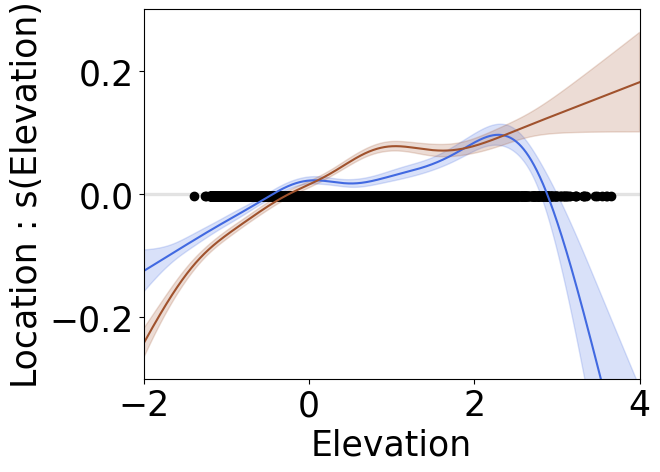

In [13]:
n = len(df_train_present)
size = 25
var = 'scale_loc1'

df = csv_documents[var]
dff = csv_documentsf[var]
plt.plot(df.alt, df.spline_values, color = 'royalblue', label = 'Present Model')
plt.fill_between(df.alt, df.ci_lower, df.ci_upper, color='royalblue', alpha=0.2)

plt.plot(dff.alt, dff.spline_values, color = 'sienna', label = 'Future Model')
plt.fill_between(dff.alt, dff.ci_lower, dff.ci_upper, color='sienna', alpha=0.2)

plt.axhspan(-0.001, 0.001, color='lightgrey', alpha=0.5, label='Highlighted Region')

plt.scatter(df_train_present.alt, [-0.00295]*n, color = 'black')

plt.ylim(-0.3, 0.3)
plt.xlim(-2, 4)

plt.xlabel('Elevation')
plt.ylabel('Location : s(Elevation)')

plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.show()

In [14]:
dico_name = {'loc_alt' : r'$\tilde{h}$', 'loc_alt_mean50' : r'$\tilde{h_m}$', 'loc_shape1' : r'$\tilde{\xi_1}$',
             'scale_loc1' : r'$\tilde{\mu_1}$', 'scale_scale1' : r'$\tilde{\sigma_1}$', 'scale_scale2' : r'$\tilde{\sigma_2}$',
             'loc_loc2' : r'$\tilde{\mu_2}$', 'loc_loc1' : r'$\tilde{\mu_1}$'}

dico_var = {'loc_alt' : 'alt', 'loc_alt_mean50' : 'alt_mean50', 'loc_shape1' : 'shape1',
             'scale_loc1' : 'loc1', 'scale_scale1' : 'scale1', 'scale_scale2' : 'scale2',
             'loc_loc2' : 'loc2', 'loc_loc1' : 'loc1'}

dico_legend = {'loc_alt' : r'$f_{\mu, h}$', 'loc_alt_mean50' : r'$f_{\mu, h_m}$', 
               'loc_shape1' : r'$f_{\mu, \xi_1}$', 'scale_loc1' : r'$f_{\sigma, \mu_1}$', 
               'scale_scale1' : r'$f_{\sigma, \sigma_1}$', 'scale_scale2' : r'$f_{\sigma, \sigma_2}$',
             'loc_loc2' : r'$f_{\mu, \mu_2}$', 'loc_loc1' : r'$f_{\mu, \mu_1}$'}

n = len(df_train_present)
n2 = len(df_train_future)

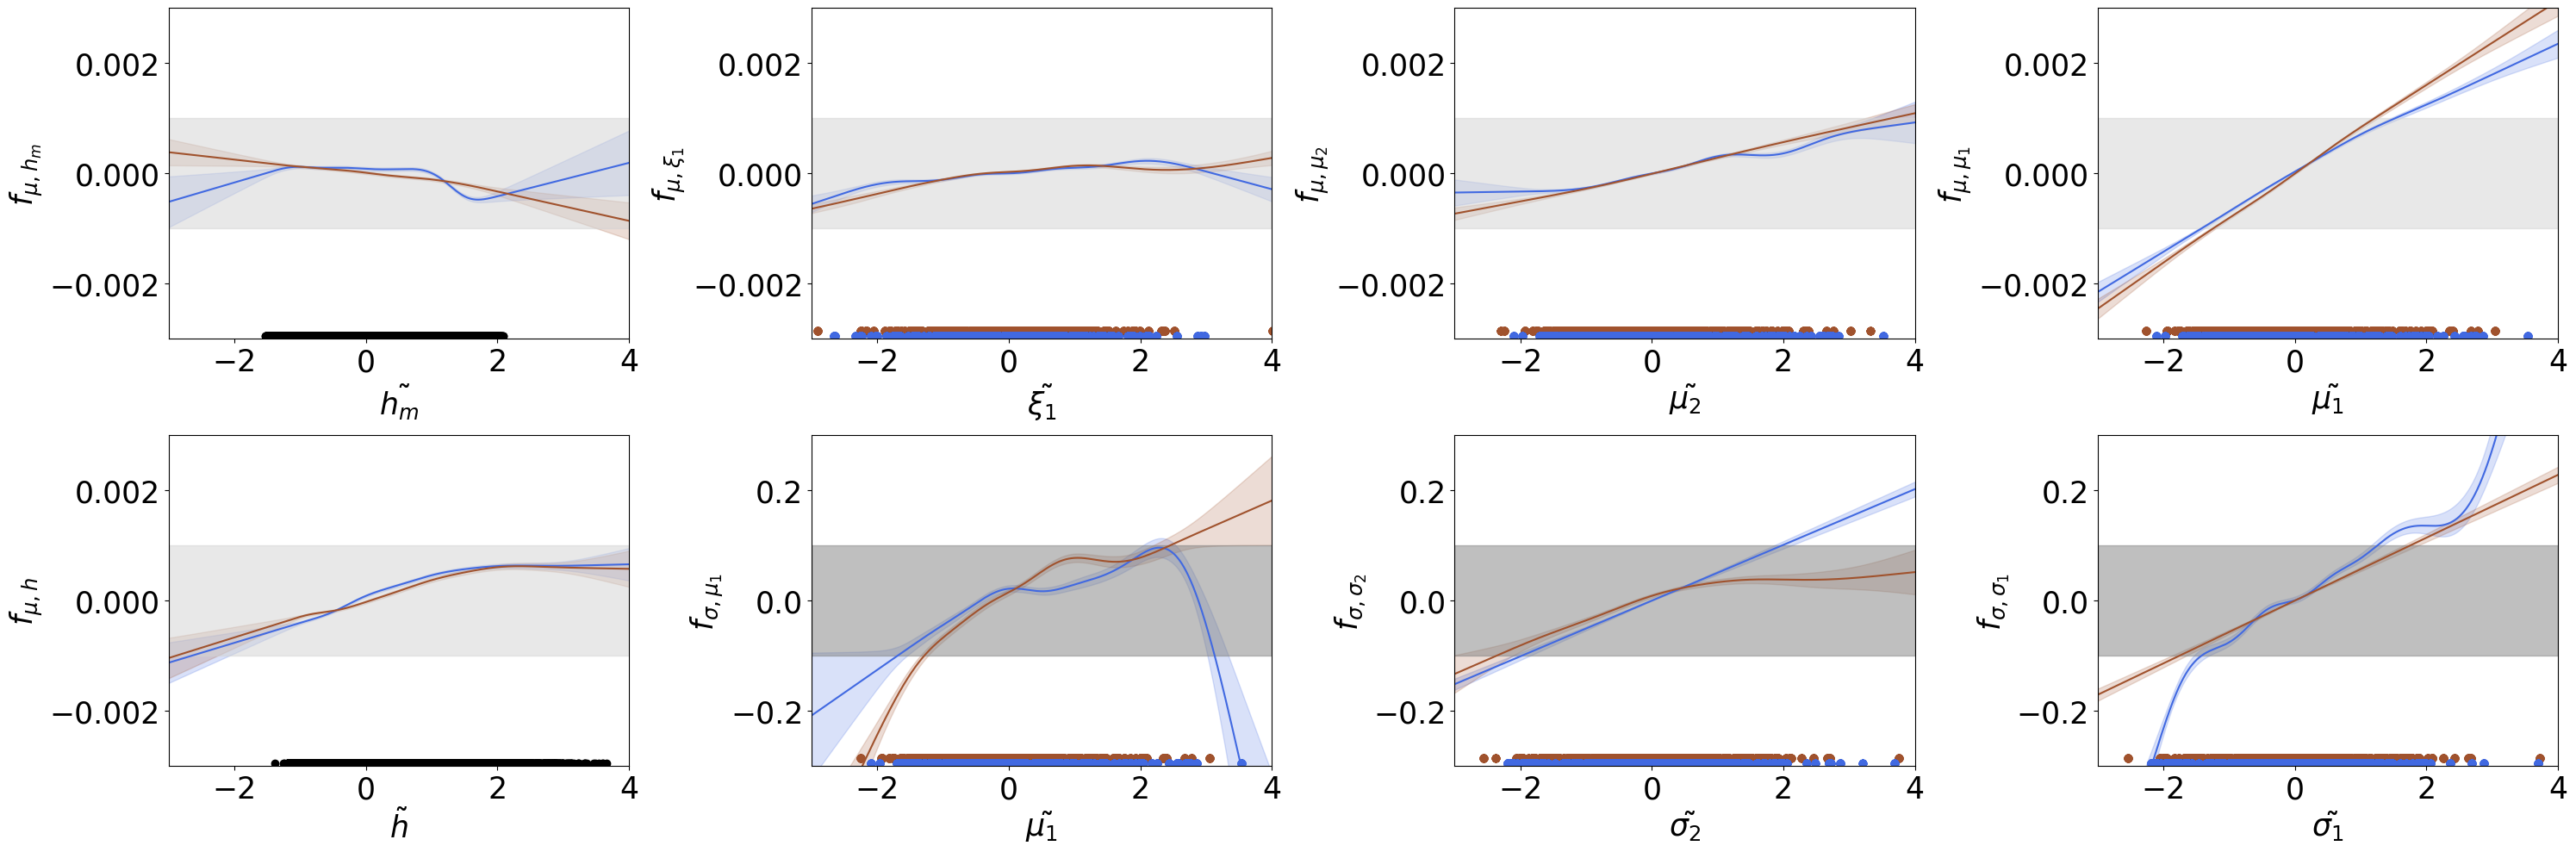

In [16]:
size = 25
matplotlib.rc('axes', titlesize=size)
matplotlib.rc('axes', labelsize=size)
matplotlib.rc('xtick', labelsize=size)
matplotlib.rc('ytick', labelsize=size)

def plot_multiple(csv_documents, csv_documentsf, df_train_present):
    """
    Crée une figure avec 8 graphiques (4 x 2) pour chaque clé de csv_documents.

    Args:
        csv_documents (dict): Dictionnaire contenant des DataFrames avec les données.
        df_train_present (DataFrame): DataFrame pour les points noirs.

    """
    n = len(df_train_present)
    fig, axes = plt.subplots(2, 4, figsize=(30, 10))
    axes = axes.flatten()

    for i, var in enumerate(csv_documents.keys()):
        if i >= 8:
            break

        if 'loc_' in var : param = 'Location'
        else : param = 'Scale'

        df = csv_documents[var]
        dff = csv_documentsf[var]
        ax = axes[i]

        ax.plot(df.alt, df.spline_values, color='royalblue', label='Present Model')
        ax.fill_between(df.alt, df.ci_lower, df.ci_upper, color='royalblue', alpha=0.2)

        ax.plot(dff.alt, dff.spline_values, color='sienna', label='Future Model')
        ax.fill_between(dff.alt, dff.ci_lower, dff.ci_upper, color='sienna', alpha=0.2)

        if param == 'Location':
            ax.set_ylim(-0.003, 0.003)
            ax.axhspan(-0.001, 0.001, color='lightgrey', alpha=0.5, label='Highlighted Region')

            if 'alt' in dico_var[var]:
                ax.scatter(df_train_present[dico_var[var]], [-0.00295] * n, color='black')
            else :
                ax.scatter(df_train_future[dico_var[var]], [-0.00285] * n2, color='sienna')
                ax.scatter(df_train_present[dico_var[var]], [-0.00295] * n, color='royalblue')


        else :
            ax.set_ylim(-0.3, 0.3)
            ax.axhspan(-0.1, 0.1, color='grey', alpha=0.5, label='Highlighted Region')
            ax.scatter(df_train_future[dico_var[var]], [-0.285] * n2, color='sienna')
            ax.scatter(df_train_present[dico_var[var]], [-0.295] * n, color='royalblue')

        ax.set_xlim(-3, 4)
        ax.set_xlabel(dico_name[var])
        ax.set_ylabel(dico_legend[var])

    plt.tight_layout()
    plt.show()

# Exemple d'appel
plot_multiple(csv_documents, csv_documentsf, df_train_present)

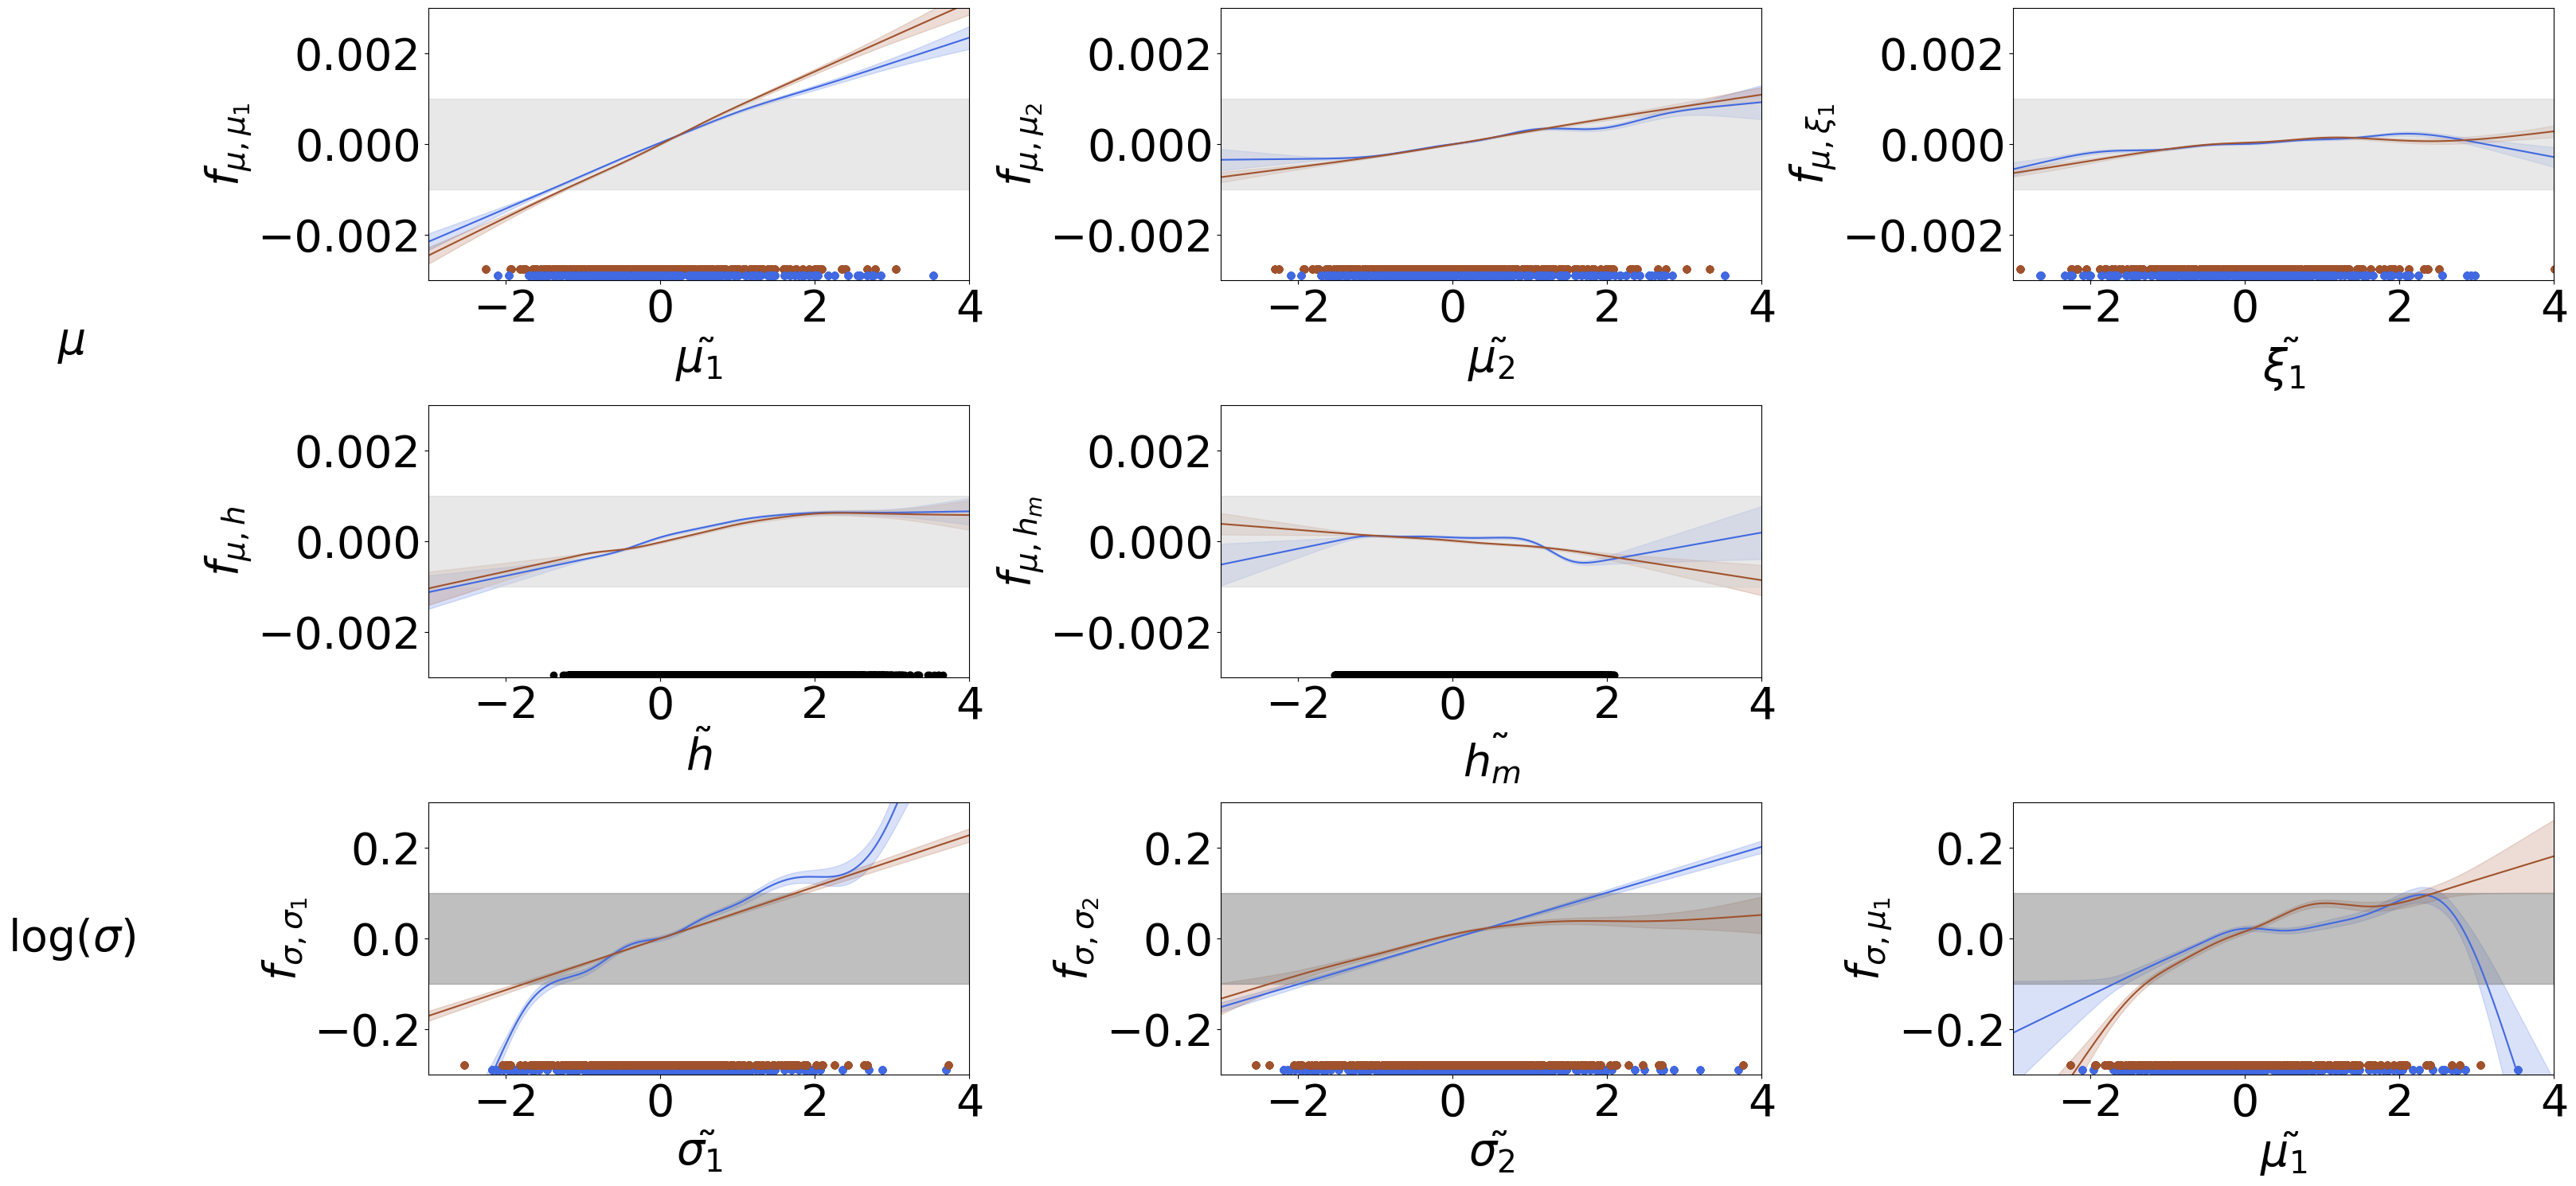

In [18]:
size = 40
matplotlib.rc('axes', titlesize=size)
matplotlib.rc('axes', labelsize=size)
matplotlib.rc('xtick', labelsize=size)
matplotlib.rc('ytick', labelsize=size)

def plot_multiple_reorganized(csv_documents, csv_documentsf, df_train_present):
    """
    Crée une figure avec 8 graphiques (3 x 3) organisés, sans le plot en haut à droite, et avec accolades.

    Args:
        csv_documents (dict): Dictionnaire contenant des DataFrames avec les données.
        df_train_present (DataFrame): DataFrame pour les points noirs.
    """
    n = len(df_train_present)
    n2 = len(df_train_future)
    fig, axes = plt.subplots(3, 3, figsize=(30, 15))
    axes = axes.flatten()

    # Ordres 
    var_order = [
        'loc_loc1', 'loc_loc2', 'loc_shape1',
        'loc_alt', 'loc_alt_mean50', None,
        'scale_scale1', 'scale_scale2', 'scale_loc1'  # None --> the empty one
    ]

    for i, var in enumerate(var_order):
        ax = axes[i]

        if var is None:
            ax.axis('off') 
            continue

        if 'loc_' in var:
            param = 'Location'
        else:
            param = 'Scale'

        df = csv_documents[var]
        dff = csv_documentsf[var]


        ax.plot(df.alt, df.spline_values, color='royalblue', label='Present Model')
        ax.fill_between(df.alt, df.ci_lower, df.ci_upper, color='royalblue', alpha=0.2)

        ax.plot(dff.alt, dff.spline_values, color='sienna', label='Future Model')
        ax.fill_between(dff.alt, dff.ci_lower, dff.ci_upper, color='sienna', alpha=0.2)

        if param == 'Location':
            ax.set_ylim(-0.003, 0.003)
            ax.axhspan(-0.001, 0.001, color='lightgrey', alpha=0.5, label='Highlighted Region')

            if 'alt' in dico_var[var]:
                ax.scatter(df_train_present[dico_var[var]], [-0.00295] * n, color='black')
            else:
                ax.scatter(df_train_future[dico_var[var]], [-0.00276] * n2, color='sienna')
                ax.scatter(df_train_present[dico_var[var]], [-0.0029] * n, color='royalblue')

        else:
            ax.set_ylim(-0.3, 0.3)
            ax.axhspan(-0.1, 0.1, color='grey', alpha=0.5, label='Highlighted Region')
            ax.scatter(df_train_present[dico_var[var]], [-0.29] * n, color='royalblue')
            ax.scatter(df_train_future[dico_var[var]], [-0.28] * n2, color='sienna')

        ax.set_xlim(-3, 4)
        ax.set_xlabel(dico_name[var])
        ax.set_ylabel(dico_legend[var])

    fig.text(-0.05, 0.7, r'$\mu$', fontsize=size, ha='center')
    fig.text(-0.05, 0.2, r'$\log(\sigma)$', fontsize=size, ha='center')

    plt.tight_layout()
    plt.show()

plot_multiple_reorganized(csv_documents, csv_documentsf, df_train_present)